In [4]:
import numpy as np 
import pandas as pd 



import os
for dirname, _, filenames in os.walk(r"C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\images_test.zip
C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\annotations\trainval.txt
C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\annotations\xmls\ABbframe00154.xml
C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\annotations\xmls\ABbframe00160.xml
C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\annotations\xmls\ABbframe00166.xml
C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\annotations\xmls\ABbframe00169.xml
C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\annotations\xmls\ABbframe00190.xml
C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\annotations\xmls\ABbframe00235.xml
C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\annotations\xmls\ABbframe00265.xml
C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\annotations\xmls\ABbframe00271.xml

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import random
import os
from PIL import Image

import pandas as pd
from xml.dom import minidom
import csv

In [ ]:
image_dir=r"C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\images"
annot_dir=r"C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\annotations\xmls"

In [4]:
import cv2
import numpy as np

def rescaling(path_image, targetSize, xmin, ymin, xmax, ymax):
    # Read the image
    imageToPredict = cv2.imread(path_image)

    # Original dimensions
    original_height = imageToPredict.shape[0]
    original_width = imageToPredict.shape[1]

    # Scaling factors
    x_scale = targetSize / original_width
    y_scale = targetSize / original_height

    # Resize image
    img_resized = cv2.resize(imageToPredict, (targetSize, targetSize))

    # Scale bounding box coordinates
    xmin_scaled = int(np.round(xmin * x_scale))
    ymin_scaled = int(np.round(ymin * y_scale))
    xmax_scaled = int(np.round(xmax * x_scale))
    ymax_scaled = int(np.round(ymax * y_scale))

    return img_resized, xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled


In [5]:
from xml.dom import minidom
import cv2

def extract_xml_contents(annot_path, image_path, target_size=300):
    """
    Extracts bounding box and class label from XML, rescales image and bbox
    """

    # Parse XML file
    file = minidom.parse(annot_path)

    # Get bounding box coordinates
    x1 = float(file.getElementsByTagName('xmin')[0].firstChild.data)
    y1 = float(file.getElementsByTagName('ymin')[0].firstChild.data)
    x2 = float(file.getElementsByTagName('xmax')[0].firstChild.data)
    y2 = float(file.getElementsByTagName('ymax')[0].firstChild.data)

    # Get class name
    class_name = file.getElementsByTagName('name')[0].firstChild.data
    class_num = 1 if class_name.lower() == 'knife' else 0

    # Get file name
    file_name = file.getElementsByTagName('filename')[0].firstChild.data

    # Resize image and bounding box
    img, xmin, ymin, xmax, ymax = rescaling(image_path, target_size, x1, y1, x2, y2)

    # Updated width/height after resizing
    width = img.shape[1]
    height = img.shape[0]

    return file_name, width, height, class_num, xmin, ymin, xmax, ymax


In [6]:
import os
import pandas as pd

def xml_to_csv(image_dir, annot_dir):
    xml_list = []

    img_files = os.listdir(image_dir)

    for image in img_files:
        # Extract base filename (without extension)
        base_filename = os.path.splitext(image)[0]

        mat_path = os.path.join(annot_dir, base_filename + '.xml')
        img_path = os.path.join(image_dir, image)

        # Check if both image and its annotation exist
        if os.path.exists(mat_path):
            try:
                value = extract_xml_contents(mat_path, img_path)
                xml_list.append(value)
            except Exception as e:
                print(f"Skipping {image} due to error: {e}")
        else:
            print(f"Annotation not found for image: {image}")

    # Column names for the dataset
    columns_name = ['file_name', 'width', 'height', 'class_num', 'xmin', 'ymin', 'xmax', 'ymax']
    
    # Convert to DataFrame
    xml_df = pd.DataFrame(xml_list, columns=columns_name)
    
    return xml_df



In [7]:
# Convert annotations to DataFrame
train_labels_df = xml_to_csv(image_dir, annot_dir)

# Save to CSV
train_labels_df.to_csv('dataset.csv', index=False)

print("✅ Annotation data saved to dataset.csv")


✅ Annotation data saved to dataset.csv


In [8]:
# Display the first 5 rows of the DataFrame
train_labels_df.head()


file_name  width  height  class_num  xmin  ymin  xmax  ymax
0  ABbframe00154.jpg    300     300          1   140   124   158   156
1  ABbframe00160.jpg    300     300          1   123   117   138   152
2  ABbframe00166.jpg    300     300          1   114   108   130   147
3  ABbframe00169.jpg    300     300          1   119   105   134   143
4  ABbframe00190.jpg    300     300          1   182   130   200   152

In [9]:
# Define sorted class list
class_list = sorted(['knife', 'no weapon'])

# Optional: Print to confirm
print("Class list:", class_list)


Class list: ['knife', 'no weapon']


In [10]:
import csv
import cv2
import os

def preprocess_dataset(image_dir, csv_file):
    labels = []
    boxes = []
    img_list = []
    none = {}  # To track any unreadable/missing images

    with open(csv_file) as csvfile:
        rows = csv.reader(csvfile)
        columns = next(iter(rows))  # Skip the header

        for i, row in enumerate(rows):
            img_path = row[0]
            full_path = os.path.join(image_dir, img_path)

            img = cv2.imread(full_path)
            if img is None:
                none[i] = str(full_path)
            else:
                img = cv2.resize(img, (300, 300))  # Resize to 300x300
                img = img.astype("float") / 255.0  # Normalize to [0, 1]

                img_list.append(img)
                labels.append(int(row[3]))  # class_num column

                # Normalize bounding boxes (xmin, ymin, xmax, ymax)
                arr = [
                    float(row[4]) / 300,
                    float(row[5]) / 300,
                    float(row[6]) / 300,
                    float(row[7]) / 300
                ]
                boxes.append(arr)

    return labels, boxes, img_list, none


In [11]:
import os
print(os.getcwd())


c:\Users\Abdul Raqeeb\major_p\frontend rafi


In [12]:
import os

base_dir = r"c:\Users\Abdul Raqeeb\major_p\frontend rafi"
csv_file = os.path.join(base_dir, "dataset.csv")


In [13]:
import os

for root, dirs, files in os.walk("C:\\Users\\Abdul Raqeeb"):
    if 'dataset.csv' in files:
        print(os.path.join(root, 'dataset.csv'))
        break


C:\Users\Abdul Raqeeb\major_p\frontend rafi\dataset.csv


In [14]:
# Call the preprocessing function on your dataset
train_labels, train_boxes, train_img, train_none = preprocess_dataset(image_dir, csv_file)

# Optional: Print stats
print(f"Total images processed: {len(train_img)}")
print(f"Missing/Unreadable images: {len(train_none)}")


Total images processed: 1000
Missing/Unreadable images: 0


In [15]:
import random

# Combine images, bounding boxes, and labels into a single list
combined_list = list(zip(train_img, train_boxes, train_labels))

# Shuffle the combined data randomly
random.shuffle(combined_list)

# Unpack the shuffled data back into separate variables
train_img, train_boxes, train_labels = zip(*combined_list)

# Optional: Convert back to list (if needed)
train_img = list(train_img)
train_boxes = list(train_boxes)
train_labels = list(train_labels)

# Confirm shuffling
print("✅ Dataset shuffled successfully!")


✅ Dataset shuffled successfully!


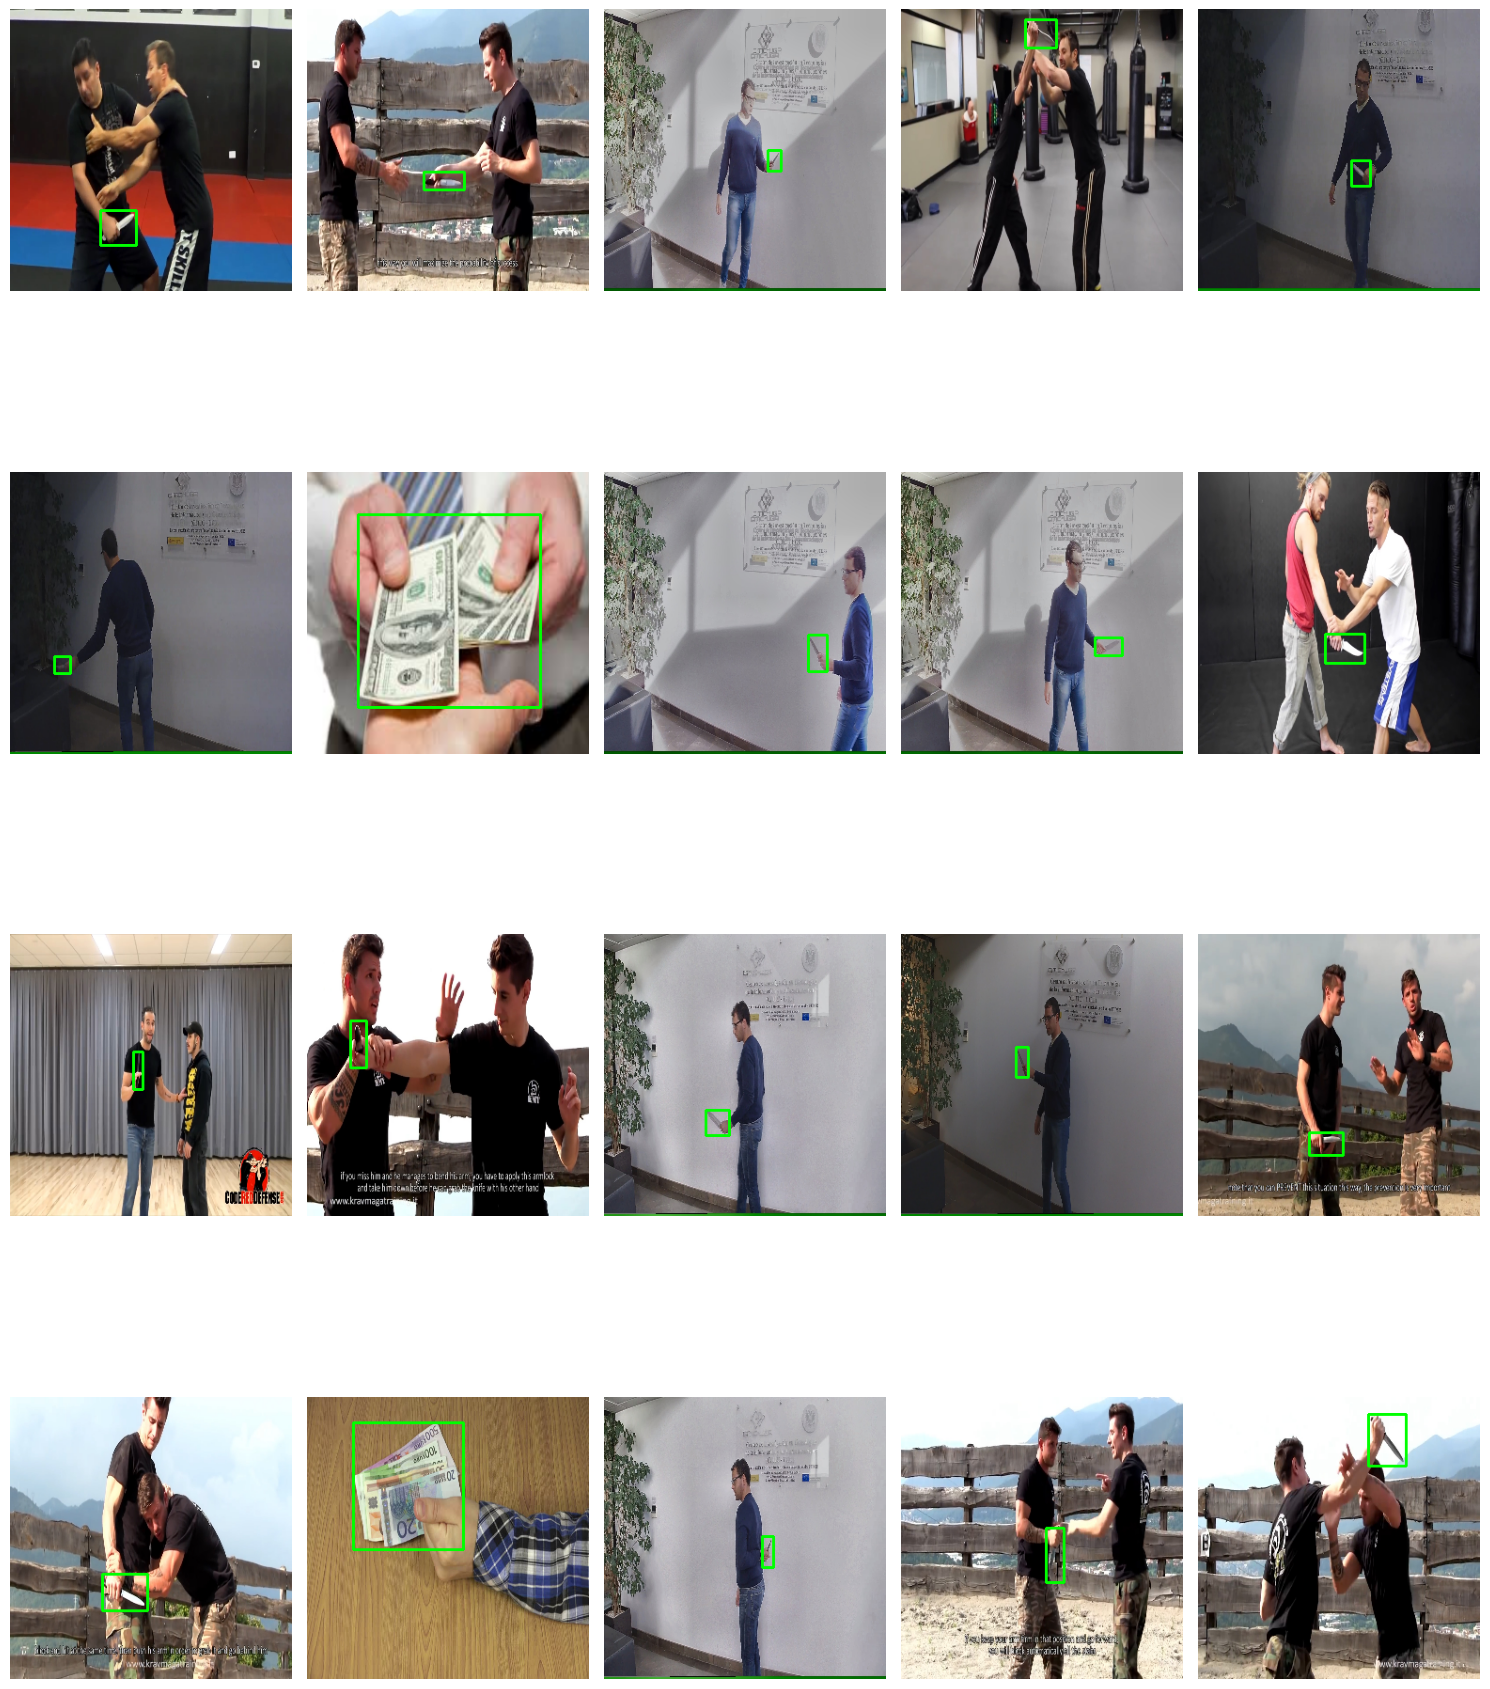

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 20))

# Pick 20 random indices
random_range = random.sample(range(len(train_img)), 20)

for itr, i in enumerate(random_range, 1):
    a1, b1, a2, b2 = train_boxes[i]
    img_size = 300

    # Scale bounding box coordinates back to original image size
    x1 = int(a1 * img_size)
    y1 = int(b1 * img_size)
    x2 = int(a2 * img_size)
    y2 = int(b2 * img_size)

    # Clone image to draw bounding box on
    image = train_img[i].copy()
    image = (image * 255).astype(np.uint8)  # Convert back to uint8 for OpenCV

    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Convert BGR (OpenCV) to RGB (matplotlib)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot
    plt.subplot(4, 5, itr)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
from sklearn.model_selection import train_test_split
import numpy as np

# Ensure these are numpy arrays before splitting
images = np.array(train_img)
labels = np.array(train_labels)
boxes = np.array(train_boxes)

# Split the dataset
train_images, val_images, train_labels_split, val_labels_split, train_boxes_split, val_boxes_split = train_test_split(
    images, labels, boxes, test_size=0.1, random_state=43
)

print(f"Total Training Images: {len(train_images)}, Total Validation Images: {len(val_images)}")


Total Training Images: 900, Total Validation Images: 100


In [18]:
import keras 
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model

from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import SGD
image_size=300

In [19]:
!pip install tensorflow


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [20]:
!pip install keras


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [21]:
import keras 
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model

from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
image_size=300

In [22]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model

image_size = 300  # Make sure this is defined
N_mobile = NASNetMobile(
    input_tensor=Input(shape=(image_size, image_size, 3)),
    include_top=False,
    weights='imagenet'
)


In [23]:
from tensorflow.keras.applications import NASNetMobile

def create_model(no_of_classes):
    # Load base model
    base_model = NASNetMobile(
        input_tensor=Input(shape=(image_size, image_size, 3)),
        include_top=False,
        weights='imagenet'
    )

    # Freeze the base model
    base_model.trainable = False
    base_model_output = base_model.output

    # Classification branch
    flattened_output = GlobalAveragePooling2D()(base_model_output)
    class_prediction = Dense(256, activation="relu")(flattened_output)
    class_prediction = Dense(128, activation="relu")(class_prediction)
    class_prediction = Dropout(0.2)(class_prediction)
    class_prediction = Dense(64, activation="relu")(class_prediction)
    class_prediction = Dropout(0.2)(class_prediction)
    class_prediction = Dense(32, activation="relu")(class_prediction)
    class_prediction = Dense(no_of_classes, activation='softmax', name="class_output")(class_prediction)

    # Bounding box regression branch
    box_output = Dense(256, activation="relu")(flattened_output)
    box_output = Dense(128, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output)
    box_output = Dense(64, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output)
    box_output = Dense(32, activation="relu")(box_output)
    box_predictions = Dense(4, activation='sigmoid', name="box_output")(box_output)

    # Final model
    model = Model(inputs=base_model.input, outputs=[box_predictions, class_prediction])

    return model


In [24]:
model = create_model(2)
model

<Functional name=functional, built=True>

In [25]:
losses = { 
    "box_output": "mean_squared_error",
    "class_output": "sparse_categorical_crossentropy"
    }

loss_weights = {
    "box_output": 1.0, 
    "class_output": 1.0
    }

metrics = {
    'class_output': 'accuracy', 
    'box_output':  'mse'
    }
stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40, 
                    restore_best_weights = True
                     )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002, 
                              patience = 30, min_lr = 1e-7, verbose = 1)
 

opt = SGD(learning_rate = 1e-3, momentum = 0.9)
 

model.compile(optimizer = opt, loss = losses, loss_weights = loss_weights, 
    metrics = metrics)

In [ ]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        x=train_images,
        y={
            "box_output": train_boxes_split,
            "class_output": train_labels_split
        },
        validation_data=(
            val_images,
            {
                "box_output": val_boxes_split,
                "class_output": val_labels_split
            }
        ),
        batch_size=32,
        epochs=100,
        callbacks=[reduce_lr, stop]
    )


Epoch 1/5


c:\Python310\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_769']
Received: inputs=Tensor(shape=(None, 300, 300, 3))
  warnings.warn(msg)


29/29 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - box_output_loss: 0.0660 - box_output_mse: 0.0660 - class_output_accuracy: 0.5380 - class_output_loss: 0.6788 - loss: 0.7450 - val_box_output_loss: 0.0679 - val_box_output_mse: 0.0615 - val_class_output_accuracy: 0.8100 - val_class_output_loss: 0.4894 - val_loss: 0.5426 - learning_rate: 0.0010
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - box_output_loss: 0.0604 - box_output_mse: 0.0604 - class_output_accuracy: 0.7827 - class_output_loss: 0.4788 - loss: 0.5393 - val_box_output_loss: 0.0623 - val_box_output_mse: 0.0559 - val_class_output_accuracy: 0.8100 - val_class_output_loss: 0.3976 - val_loss: 0.4474 - learning_rate: 0.0010
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - box_output_loss: 0.0565 - box_output_mse: 0.0564 - class_output_accuracy: 0.7652 - class_output_loss: 0.4431 - loss: 0.5001 - val_box_output_loss: 0.0592 - val_box_output_mse: 0.0527 - val_class_output_accuracy: 0.8200 - val_class_output_loss: 0.3204 - val_loss: 0.370

In [34]:
def plot(var1, var2, plot_name):
  
    c1 = history.history[var1]
    c2 = history.history[var2]
 
    epochs = range(len(c1)
                )
   
    plt.plot(epochs, c1, 'b', label=var1)
    plt.plot(epochs, c2, 'r', label=var2)
    plt.title(str(plot_name))
    plt.legend()

In [28]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Define the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

# Regression head for bounding boxes
bbox_output = Dense(4, activation='sigmoid', name='bbox')(x)

# Classification head
class_output = Dense(3, activation='softmax', name='class')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=[bbox_output, class_output])


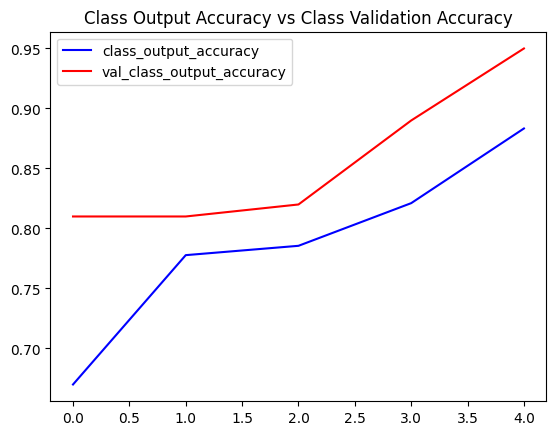

In [29]:
plot( 'class_output_accuracy', 'val_class_output_accuracy', 'Class Output Accuracy vs Class Validation Accuracy')

In [30]:
model.save('caltech_normal.h5')

In [31]:
model.compile(
    optimizer='adam',
    loss={'bbox': 'mse', 'class': 'sparse_categorical_crossentropy'},
    metrics={'bbox': 'mae', 'class': 'accuracy'}
)


In [32]:
!pip install opencv-python numpy tensorflow matplotlib


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Raw Class Output: [[0.19821197 0.75920284 0.04258522]]
Raw Box Output: [[0.8600479  0.32221764 0.5951232  0.77894884]]


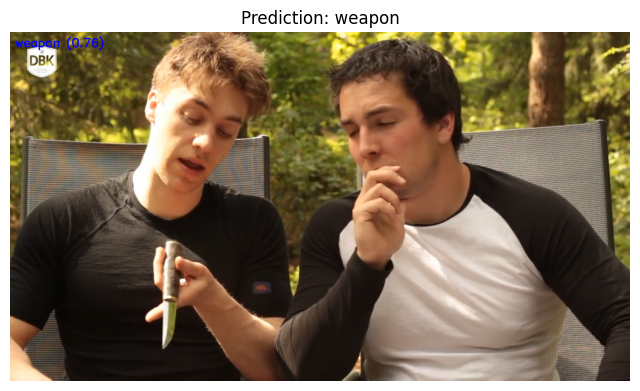

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model without compiling (since it's used only for prediction)
model = tf.keras.models.load_model('caltech_normal.h5', compile=False)

def preprocess_image(image_path, image_size=224):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_and_display(image_path):
    img = cv2.imread(image_path)
    processed_img = preprocess_image(image_path)

    box_output, class_output = model.predict(processed_img)

    print(f"Raw Class Output: {class_output}")
    print(f"Raw Box Output: {box_output}")  # Optional: remove this if you don't want to see it

    class_index = np.argmax(class_output)
    confidence = np.max(class_output)

    class_labels = ["No Weapon", "weapon"]
    label = class_labels[class_index] if class_index < len(class_labels) else "Unknown"

    if confidence < 0.5:
        print("⚠️ Low confidence! Prediction might be uncertain.")
        label = "Uncertain"

    # Just draw the label text at the top-left corner
    cv2.putText(img, f"{label} ({confidence:.2f})", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    # Show the image
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Prediction: {label}')
    plt.show()

# Test image
test_image_path = r"C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\images_test\images_test\knife_830.jpg"
predict_and_display(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Raw Class Output: [[0.14859337 0.571074   0.28033268]]
Raw Box Output: [[0.8557194  0.43011472 0.27018344 0.8517807 ]]
⚠️ Low confidence! No bounding box will be drawn.
Converted Bounding Box: (1642, 550), (518, 1091)
⚠️ Invalid bounding box! No box will be drawn.


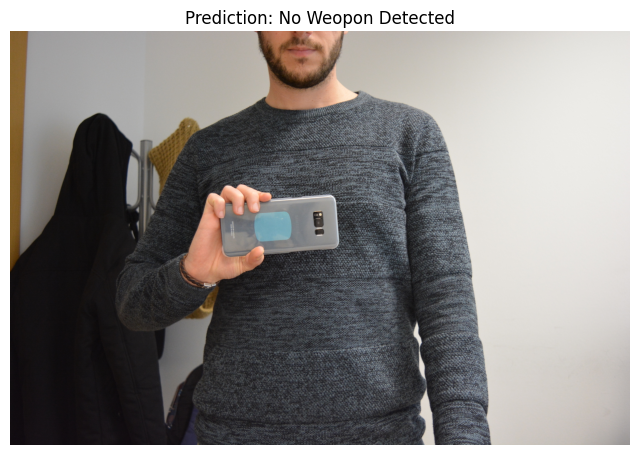

In [ ]:
import cv2
import numpy as np
import tensorflow as tf  
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('caltech_normal.h5')

def preprocess_image(image_path, image_size=224):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_and_display(image_path):
    """ Predicts weapon presence and displays results """
    img = cv2.imread(image_path)
    processed_img = preprocess_image(image_path)

    # Make predictions
    box_output, class_output = model.predict(processed_img)

    # Debugging: Print raw outputs
    print(f"Raw Class Output: {class_output}")  # Print raw classification scores
    print(f"Raw Box Output: {box_output}")  # Print raw bounding box coordinates

    # Get predicted class and confidence
    class_index = np.argmax(class_output)  
    confidence = np.max(class_output)

    # Class labels
    class_labels = ["No Weapon", "Knife", "Gun"]  
    label = class_labels[class_index] if class_index < len(class_labels) else "Unknown"

    # Apply confidence threshold
    if confidence < 0.9:
        print("⚠️ Low confidence! No bounding box will be drawn.")
        label = "No Weopon Detected"

    # Get bounding box coordinates
    h, w = img.shape[:2]
    x1, y1, x2, y2 = box_output[0]

    # Convert to pixel coordinates
    x1, y1 = int(w * x1), int(h * y1)
    x2, y2 = int(w * x2), int(h * y2)

    # Ensure coordinates are within image bounds
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    print(f"Converted Bounding Box: ({x1}, {y1}), ({x2}, {y2})")

    # Check if bounding box is valid
    if x1 >= x2 or y1 >= y2:
        print("⚠️ Invalid bounding box! No box will be drawn.")
    else:
        # Draw bounding box only if weapon is detected
        if label in ["Knife", "Gun"]:
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"{label} ({confidence:.2f})", (x1, max(30, y1 - 10)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Display image
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Prediction: {label}')
    plt.show()

# Provide the path to your test image
test_image_path = r"C:\Users\Abdul Raqeeb\major_p\frontend rafi\weapon-Detection-images\images_test\smartphone_1056.jpg"
predict_and_display(test_image_path)
